# Demo: Semantic Kernel, Plugins, Functions, Planner

## 💾 Install packages

In [1]:
#r "nuget: Microsoft.SemanticKernel, 1.3.0"
#r "nuget: Microsoft.SemanticKernel.Abstractions, 1.3.0"
#r "nuget: Microsoft.SemanticKernel.Plugins.Core, 1.3.0-alpha"
#r "nuget: Microsoft.SemanticKernel.Plugins.Web, 1.3.0-alpha"
#r "nuget: Microsoft.SemanticKernel.Planners.Handlebars, 1.3.0-preview"
#r "nuget: Microsoft.Extensions.Logging.Console, 8.0.0"
#r "nuget: SkiaSharp, 2.88.3"

Installed Packages Microsoft.Extensions.Logging.Console, 8.0.0 Microsoft.SemanticKernel, 1.3.0 Microsoft.SemanticKernel.Abstractions, 1.3.0 Microsoft.SemanticKernel.Planners.Handlebars, 1.3.0-preview Microsoft.SemanticKernel.Plugins.Core, 1.3.0-alpha Microsoft.SemanticKernel.Plugins.Web, 1.3.0-alpha SkiaSharp, 2.88.3

## 🔥 Fire up the kernel

⚠️ Make sure to use a model that allows OpenAI function-calling.

In [2]:
#!import config/Settings.cs
#!import config/Utils.cs
#!import config/SkiaUtils.cs

#pragma warning disable SKEXP0001, SKEXP0002, SKEXP0011, SKEXP0012

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Connectors.OpenAI;
using Microsoft.SemanticKernel.Planning.Handlebars;
using Microsoft.Extensions.Logging;
using Kernel = Microsoft.SemanticKernel.Kernel;
using Microsoft.SemanticKernel.Plugins.Web;
using Microsoft.SemanticKernel.Plugins.Web.Bing;
using Microsoft.SemanticKernel.TextToImage;
using Microsoft.SemanticKernel.Services;

Kernel kernel;

var (useAzureOpenAI, model, azureEndpoint, apiKey, orgId, email, bing) = Settings.LoadFromFile();
kernel = Kernel.CreateBuilder()
    .AddAzureOpenAIChatCompletion(model, azureEndpoint, apiKey)
    .AddAzureOpenAITextToImage("dall-e-3", azureEndpoint, apiKey)
    .Build();


## ⌚️ Declare & import a plugin with a native .NET function

In [3]:
using System.ComponentModel;
using Microsoft.Extensions.Logging;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Plugins.Core;

public class TimeInformationPlugin
{
    [KernelFunction]
    [Description("Retrieves the current time in UTC.")]
    public string GetCurrentUtcTime() => DateTime.UtcNow.ToString("R");
}

kernel.ImportPluginFromType<TimeInformationPlugin>();

## 🪴 Reduce hallucination of an LLM via grounding

Invoke kernel with a prompt that asks the model for information it cannot provide => likely to hallucinate.

In [4]:
Console.WriteLine(await kernel.InvokePromptAsync(
    "How many days until Christmas?"));

There are 47 days until Christmas.


Use the  `TimeInformationPlugin` plugin from above in the templated prompt. Now, the LLM is "thinking out loud", based on the right information to start from. 

In [5]:
Console.WriteLine(await kernel.InvokePromptAsync(
    "The current time is {{TimeInformationPlugin.GetCurrentUtcTime}}. How many days until Christmas?"));

There are 289 days until Christmas.


Now, allow the AI to ***automatically*** invoke functions. Note that we're hoping it will find `TimeInformationPlugin` -- keep in mind that this depends on the quality of the name & description of your plugin(s) and function(s). Also show streaming of model response data.

In [6]:
OpenAIPromptExecutionSettings settings = new() { ToolCallBehavior = ToolCallBehavior.AutoInvokeKernelFunctions };
var results = kernel.InvokePromptStreamingAsync(
    "How many days until Christmas? Explain your thinking.", new(settings));
await foreach (var message in results)
{
    Console.Write(message);
} 

Christmas is 287 days away! 

Here's the breakdown of the calculation:
1. Find out the current date: March 11, 2024
2. Calculate the number of days until December 25, 2024: 289 days

So, there are 289 days remaining until Christmas.

Import the built-in web search plugin 🔎 with the Bing connector to get up-to-date information. 

In [7]:
#pragma warning disable SKEXP0054

// Load Bing plugin
var bingConnector = new BingConnector(bing);
kernel.ImportPluginFromObject(new WebSearchEnginePlugin(bingConnector), "bing");
var results = kernel.InvokePromptStreamingAsync("Who won the oscar for best movie in 2024?", new KernelArguments(settings));
await foreach (var message in results)
{
    Console.Write(message);
} 

The movie "Oppenheimer" won the Oscar for Best Picture in 2024.

## 📨 Declare & import a plugin with a semantic function

Let's create a custom plugin for classification of text in terms of spam or not.

In [8]:
using Microsoft.SemanticKernel.Connectors.OpenAI;

public class SpamPlugin
{
    [KernelFunction]
    [Description("Tells you whether a given text is spam.")]
    public async Task<string> ClassifySpam(Kernel kernel, 
        [Description("The text that will be classified")] string input)
    {
        KernelArguments args = new(
            new OpenAIPromptExecutionSettings { MaxTokens = 256, Temperature = 0.0 }) { { "input", input } };
        var result = await kernel.InvokePromptAsync(
            @"
            Decide whether a message is spam or not from it's content, and tone.
            Only use one of the two categories that follow and nothing else:
            Categories: spam, not spam 

            Examples
            Message: You've won!
            Category: spam

            Message: Claim your gift card!
            Category: spam

            Message: where do we request this for our customers?
            Category: not spam

            Message: {{$input}}
            Category:
            ", 
            args); 
        return result.ToString();
    }
}

var spamPlugin = kernel.ImportPluginFromType<SpamPlugin>();

Invoke the plugin function directly.

In [9]:
var msg1 = "Congratulations, you won!";
Console.WriteLine(msg1 + " => " + await kernel.InvokeAsync(spamPlugin["ClassifySpam"], new() { ["input"] = msg1 } ));
var msg2 = "Hey don't forget our meeting tomorrow";
Console.WriteLine(msg2 + " => " + await kernel.InvokeAsync(spamPlugin["ClassifySpam"], new() { ["input"] = msg2 } ));

Congratulations, you won! => spam
Hey don't forget our meeting tomorrow => not spam


Show that we can also use the kernel to work with other AI models like DALL-E to generate images 🧙.


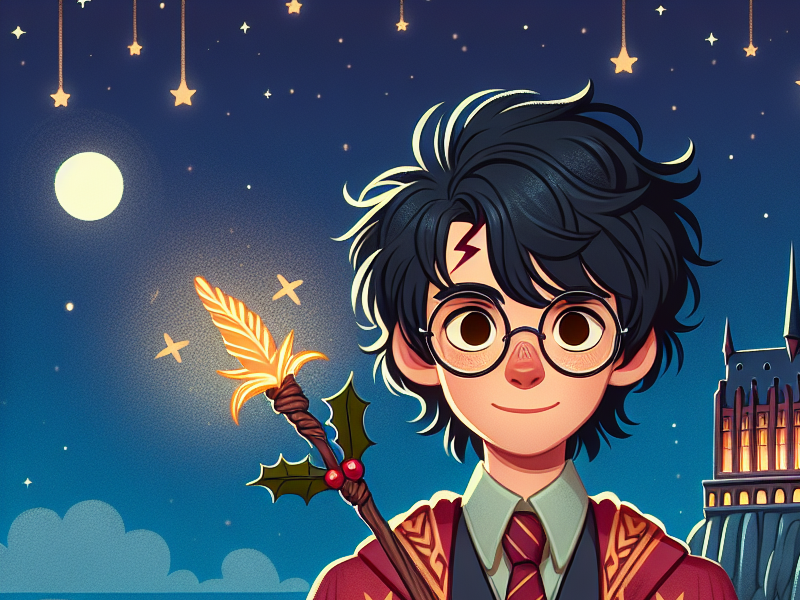

In [10]:
#pragma warning disable SKEXP0002

// Get AI service instance used to generate images
var dallE = kernel.GetRequiredService<ITextToImageService>();

var prompt = @"
Cute Harry Potter, pixar animated movie style, standing outside Hogwarts in a thunderstorm with lightning at night.";

var executionSettings = new OpenAIPromptExecutionSettings 
{
    MaxTokens = 256,
    Temperature = 1
};

// Create a semantic function that generate a random image description.
var genImgDescription = kernel.CreateFunctionFromPrompt(prompt, executionSettings);

var random = new Random().Next(0, 200);
var imageDescriptionResult = await kernel.InvokeAsync(genImgDescription, new() { ["input"] = random });
var imageDescription = imageDescriptionResult.ToString();

// Use DALL-E 3 to generate an image. OpenAI in this case returns a URL (though you can ask to return a base64 image)
var imageUrl = await dallE.GenerateImageAsync(imageDescription.Trim(), 1024, 1024);
await SkiaUtils.ShowImage(imageUrl, 800, 600);

## 📋 Use the Planner 

Planner takes a user's ask and (using an LLM) creates a plan. It makes use of the collection of plugins that have been registered to the kernel and combines them into a series of steps that complete the goal.

Let's add a plugin 🔌 to send emails. 


In [11]:
using System;
using System.IO;
using System.Net;
using System.Net.Http;
using System.Net.Http.Headers;
using System.Threading.Tasks;
using System.ComponentModel;
using Newtonsoft.Json;

public class EmailPlugin
{
    [KernelFunction, Description("Given an e-mail and message body, send an email")]
    public async Task<string> SendEmail(
        [Description("The body of the email message to send.")] string input,
        [Description("The email address to send email to.")] string email_address) {
            StringContent httpContent = new StringContent(
                JsonConvert.SerializeObject(new { to = email_address, content = input }), 
                    System.Text.Encoding.UTF8, "application/json");
            var response = await new HttpClient().PostAsync(File.ReadAllText("config/email_endpoint.txt"), httpContent);
            return response.StatusCode == HttpStatusCode.Accepted ? 
                $"Email sent to: {email_address}." : $"Error sending email";
    }

}
kernel.ImportPluginFromType<EmailPlugin>();

Generate a plan for an ask containing multiple steps.

In [12]:
#pragma warning disable SKEXP0060

var planner = new HandlebarsPlanner();
var ask = @$"Provide the current time and the name of the city where the company Carl Zeiss was founded. 
            Send the result as an email to {email}";
var plan = await planner.CreatePlanAsync(kernel, ask);

Console.WriteLine("The proposed plan in Handlebars format:\n");
Console.WriteLine(plan);

The proposed plan in Handlebars format:

{{!-- Step 1: Create a variable to store the current UTC time --}}
{{set "currentTime" (TimeInformationPlugin-GetCurrentUtcTime)}}

{{!-- Step 2: Create a variable to store the city where the company Carl Zeiss was founded --}}
{{set "companyLocation" "Jena"}}

{{!-- Step 3: Create a variable to store the email message body --}}
{{set "emailBody" (concat "Current time in UTC: " (json currentTime) ". Carl Zeiss was founded in " companyLocation)}}

{{!-- Step 4: Send the email with the message body to ...@microsoft.com --}}
{{set "emailResult" (EmailPlugin-SendEmail input=emailBody email_address="...@microsoft.com")}}

{{!-- Step 5: Output the result of sending the email --}}
{{json emailResult}}


Let's run the plan 🚲.

In [13]:
#pragma warning disable SKEXP0060

var planResult = await plan.InvokeAsync(kernel, new KernelArguments());
planResult

Email sent to: ...@microsoft.com.